In [1]:
import random
import torch
from torch import nn
from torch.distributions.categorical import Categorical
from Levenshtein import distance
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Define the forward probability $P_F$

In [2]:
# Define chunk vocabulary examples
three_letter_chunks = ["AAA", "BBB", "CCC", "ACC", "BCA", "CCB", "AAB", "BBC", "CCA"]
six_letter_chunks = [
    "AAABBB",
    "BBACCC",
    "CCBAAA",
    "ACBBBC",
    "BACACC",
    "CBBAAA",
    "ABCABC",
    "BCACBC",
    "CACABC",
]
nine_letter_chunks = [
    "AAABBBCAC",
    "BBCACCCBB",
    "CCBBBAAAB",
    "ACBBBCBAA",
    "BACACACAC",
    "CBBAAAACA",
    "ABCBCBABA",
    "BCACABCCC",
    "CACABCBBB",
]

# Define rules for generating sentences (for now only if starts then can end with)
rules = [
    ("AAA", ["AAA", "CCC", "BBB", "AAC", "AAABBBCCC"]),
    ("BBB", ["BBB", "AAA", "CCC", "BCA", "CCBAAABBB"]),
    ("CCC", ["CCC", "BBB", "AAA", "ACC", "BBCAACCCC"]),
    ("ACC", ["CBB", "BBB", "CAC", "AAABBBCAC"]),
    ("BCA", ["CAC", "ABC", "BAC", "ACBBBCBAA"]),
    ("CCB", ["BBB", "ABC", "CCA", "ABCBCBABA"]),
]

# Generate a dataset of sentences
def generate_sentence(max_len=30):
    assert max_len % 3 == 0, "The maximum length should be a multiple of 3."
    assert max_len > 6, "The maximum length should be longer than 6."
    while True:
        start_chunk, end_chunks = random.choice(rules)
        middle_chunk = random.choice(six_letter_chunks + nine_letter_chunks)
        end_chunk = random.choice(end_chunks)
        sentence = start_chunk + middle_chunk + end_chunk
        if len(sentence) != max_len:
            # If the sentence length is not 30, modify the middle_chunk by adding 3-letter tokens
            required_length = max_len - len(sentence)
            if required_length <= 0:
                continue  # Skip this iteration if the middle_chunk is too long
            middle_chunk += "".join(
                random.choice(three_letter_chunks) for _ in range(required_length // 3)
            )
            sentence = start_chunk + middle_chunk + end_chunk
        return sentence
class ChunkDataset(Dataset):
    def __init__(self, max_len=30, num_sentences=1000):
        self.vocab2token = {k: i for i, k in enumerate(["A", "B", "C"])}
        self.token2vocab = {i: k for i, k in enumerate(["A", "B", "C"])}
        self.num_sentences = num_sentences
        self.data = [generate_sentence(max_len) for _ in range(num_sentences)]

    def __len__(self):
        return self.num_sentences

    def __getitem__(self, i):
        vec = torch.tensor([self.vocab2token[k] for k in self.data[i]])
        out = torch.zeros((len(vec), len(self.vocab2token)))
        out[range(len(vec)), vec] = 1
        return out

In [3]:
class MLP(nn.Module):
    def __init__(self, num_layers, hidden_dim, vocab_size, act):
        super(MLP, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, hidden_dim)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2*hidden_dim, hidden_dim))
        self.layers.append(act)
        for _ in range(self.num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(act)
        self.layers.append(nn.Linear(hidden_dim, vocab_size))
        
        self.logZ = nn.Parameter(torch.ones(1))
    
    def forward(self, x, state):
        """
        Args:
            x [B, N, dim]
            state [B, M, dim]
        """
        x_ = self.embedding(x).mean(1)
        s = self.embedding(state).mean(1)
        
        out = torch.cat([x_, s], dim=-1)
        for layer in self.layers:
            out = layer(out)
        return out

In [4]:
class RNN(nn.Module):
    def __init__(self, num_layers, hidden_dim, vocab_size, act):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, hidden_dim)
        
        self.rnn_encoder = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(act)
        for _ in range(self.num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(act)
        self.layers.append(nn.Linear(hidden_dim, vocab_size))
        
        self.pool = nn.Linear(vocab_size, 1)
            
    def forward(self, x, state):
        """
        Args:
            x [B, N, dim]
            state [B, M, dim]
        """
        
        x__, x_ = self.rnn_encoder(self.embedding(x))
        s, _ = self.rnn_encoder(self.embedding(state), x_)
        out = s[:,-1]
        logZ = x__[:,-1]
        for layer in self.layers:
            out = layer(out)
            logZ = layer(logZ)
        logZ = self.pool(logZ)
        return out, logZ

In [5]:
class Vocabulary:
    def __init__(self, vocab):
        self.vocab = vocab
        
    def s2v(self, sample):
        if sample == "":
            return np.zeros((1,len(self.vocab)))
        indices = [self.vocab.index(element) for element in sample]
        vec = np.zeros((len(sample), len(self.vocab)))
        vec[range(len(sample)),indices] = 1
        return vec
    
    def __len__(self):
        return len(self.vocab)
    
    def v2s(self, vec):
        indices = np.argmax(vec, axis=-1)
        return "".join([self.vocab[i] for i in indices])

In [6]:
vocab = Vocabulary(["A", "B", "C"])
batch_size = 32
# Generate a dataset with a specified number of sentences
num_sentences = 1000
max_len = 12
dataset = ChunkDataset(max_len, 1000)
dataloader = DataLoader(dataset, batch_size=batch_size)
P_F = RNN(1, 128, 3, nn.ReLU()).cuda()
opt = torch.optim.Adam(P_F.parameters(),  3e-4)
max_states = len(vocab)**max_len

In [7]:
tb_losses = []
logZs = []
sampled_states = set()
logrewards = []
coverage = []

In [8]:
for epoch in tqdm(range(500)):
    for batch in dataloader:
        x = batch.cuda().float()
        state = torch.from_numpy(vocab.s2v("")).float().unsqueeze(0).cuda().repeat(x.shape[0], 1, 1)
        p_f_s, logZ = P_F(x, state)
        log_pf = 0
        log_pb = 0
        for t in range(max_len):
            cat = Categorical(logits=p_f_s)
            act = cat.sample()
            action = torch.zeros((x.shape[0], len(vocab))).float().cuda()
            action.scatter_(-1, act.unsqueeze(-1), 1)
            action = action.unsqueeze(1)
            log_pf += cat.log_prob(act)
            if t==0:
                new_state = action
            else:
                new_state = torch.cat([state, action], dim=1)
            p_f_s, logZ = P_F(x, new_state)
            state = new_state
        logreward = -((x-state).pow(2)).sum((1,2))
        print(logreward)
        loss = (logZ+log_pf-logreward-log_pb).pow(2).mean()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        tb_losses.append(loss.item())
        logZs.append(logZ.mean().item())
        logrewards.append(logreward.mean().item())
        sampled_states.union(set([vocab.v2s(state[i].detach().cpu().long()) for i in range(state.shape[0])]))
        coverage.append(len(set(sampled_states))/max_states)
    
        
        print("loss:", loss.item(), "logreward:", logreward.mean().item(), "logZ:", logZ.mean().item())

  0%|          | 0/500 [00:00<?, ?it/s]

tensor([-16., -12., -10., -18., -16., -14., -20., -18., -12., -18., -18., -20.,
        -18., -24., -16., -10., -16., -16., -16., -18., -20., -12., -24., -14.,
        -16., -18., -24.,  -8., -12., -18., -16., -16.], device='cuda:0')
loss: 21.486875534057617 logreward: -16.375 logZ: -0.5377994179725647
tensor([-14., -20., -16., -16., -14., -18., -16., -10., -16., -12., -18., -18.,
        -12., -14., -20., -22., -18., -16., -12., -16., -10., -16., -20., -16.,
        -20., -16., -16., -14., -16., -18., -12., -16.], device='cuda:0')
loss: 13.033182144165039 logreward: -15.875 logZ: -0.5435402393341064
tensor([-16., -22., -14., -22., -14., -14., -14., -16., -16., -14., -16., -14.,
        -20., -16., -16., -20., -14., -14., -12., -10., -16., -18., -22., -10.,
        -14., -14., -18., -14., -12., -20., -16., -16.], device='cuda:0')
loss: 14.665635108947754 logreward: -15.75 logZ: -0.5483478307723999
tensor([-14., -16., -10., -20., -16., -16., -20., -20., -12., -18., -14., -16.,
        -

KeyboardInterrupt: 

In [29]:
def running_average(arr):
    cumsum = np.cumsum(arr)  # Calculate cumulative sum of the array
    indices = np.arange(1, len(arr) + 1)  # Create an array of indices from 1 to len(arr)
    averages = cumsum / indices  # Calculate the running averages
    return averages

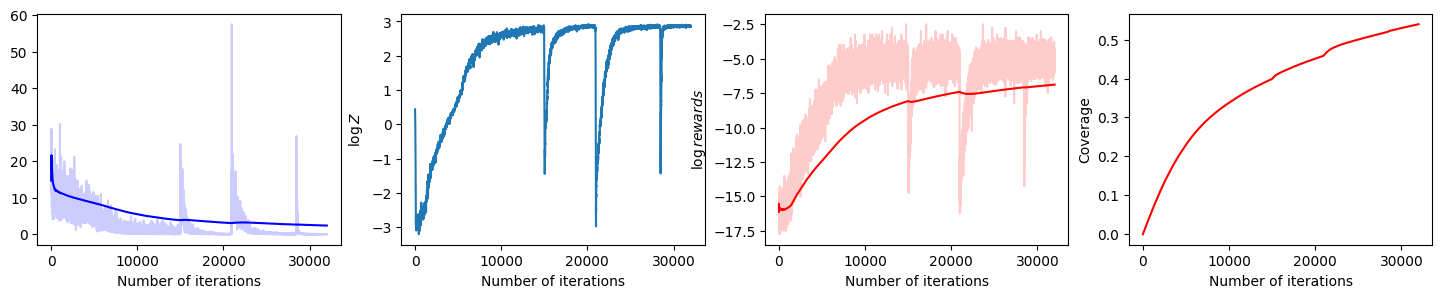

In [30]:
fig, ax = plt.subplots(1,4,figsize=(18,3))
ax[0].plot(tb_losses, alpha=0.2, color="blue")
ax[0].plot(running_average(tb_losses), color="blue")
ax[0].set_xlabel("Number of iterations")
ax[1].set_ylabel("TB loss")

ax[1].plot(logZs)
ax[1].set_ylabel("$\log Z$")
ax[1].set_xlabel("Number of iterations")

ax[2].plot(logrewards, alpha=0.2, color="red")
ax[2].plot(running_average(logrewards), color="red")
ax[2].set_ylabel("$\log rewards$")
ax[2].set_xlabel("Number of iterations")

ax[3].plot(coverage, alpha=1, color="red")
# ax[2].plot(running_average(logrewards), color="red")
ax[3].set_ylabel("Coverage")
ax[3].set_xlabel("Number of iterations")

plt.show()